# PINN for Navier Strokes Equations

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## Brief Overview of Navier Strokes Equations

In [8]:
class Model(nn.Module):
    def __init__(self, hidden_channels:int) -> None:
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(3, hidden_channels),
            nn.Tanh(),
            nn.Linear(hidden_channels, hidden_channels),
            nn.Tanh(),
            nn.Linear(hidden_channels, hidden_channels),
            nn.Tanh(),
            nn.Linear(hidden_channels, hidden_channels),
            nn.Tanh(),
            nn.Linear(hidden_channels, 3)
        )

    
    def forward(self, x:torch.Tensor, y:torch.Tensor, t:torch.Tensor) -> torch.Tensor:
        inputs = torch.cat([x, y, t], dim=-1)
        output = self.network(inputs)
        u, v, p = output[:, 0:1], output[:, 1:2], output[:, 2:3]
        return u, v, p

In [9]:
rho = 1.0
nu = 0.01

In [10]:
x_train = torch.rand(100, 1, requires_grad=True)
y_train = torch.rand(100, 1, requires_grad=True)
t_train = torch.rand(100, 1, requires_grad=True)

In [22]:
pinn = Model(128)
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)

num_training_steps = 15000
for training_step in range(num_training_steps):
    optimizer.zero_grad()

    u, v, p = pinn(x_train, y_train, t_train)

    u_x = torch.autograd.grad(u, x_train, torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y_train, torch.ones_like(u), create_graph=True)[0]
    u_t = torch.autograd.grad(u, t_train, torch.ones_like(u), create_graph=True)[0]

    v_x = torch.autograd.grad(v, x_train, torch.ones_like(v), create_graph=True)[0]
    v_y = torch.autograd.grad(v, y_train, torch.ones_like(v), create_graph=True)[0]
    v_t = torch.autograd.grad(v, t_train, torch.ones_like(v), create_graph=True)[0]

    p_x = torch.autograd.grad(p, x_train, torch.ones_like(p), create_graph=True)[0]
    p_y = torch.autograd.grad(p, y_train, torch.ones_like(p), create_graph=True)[0]

    u_xx = torch.autograd.grad(u_x, x_train, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y_train, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    v_xx = torch.autograd.grad(v_x, x_train, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
    v_yy = torch.autograd.grad(v_y, y_train, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]

    continuity = u_x + v_y

    momentum_u = u_t + u * u_x + v * u_y + p_x / rho - nu * (u_xx + u_yy)
    momentum_v = v_t + u * v_x + v * v_y + p_y / rho - nu * (v_xx + v_yy)

    loss = torch.mean(continuity**2) + torch.mean(momentum_u**2) + torch.mean(momentum_v**2)

    loss.backward()
    optimizer.step()

    if training_step % 1000 == 0:
        print(f'Training Step {training_step}, Loss: {loss.item()}')

Training Step 0, Loss: 0.0015044992323964834
Training Step 1000, Loss: 2.430676815379229e-08
Training Step 2000, Loss: 9.079303531223104e-09
Training Step 3000, Loss: 3.379772461897801e-09
Training Step 4000, Loss: 1.2837519935970931e-09
Training Step 5000, Loss: 4.260926611543425e-10
Training Step 6000, Loss: 2.362328388461066e-10
Training Step 7000, Loss: 9.268812800611315e-11
Training Step 8000, Loss: 7.5374331776068e-11
Training Step 9000, Loss: 5.097697264311307e-11
Training Step 10000, Loss: 1.287868423016647e-11
Training Step 11000, Loss: 5.6458201669329355e-08
Training Step 12000, Loss: 4.9489163878035924e-09
Training Step 13000, Loss: 2.7023587811925154e-09
Training Step 14000, Loss: 1.3284957578463263e-09


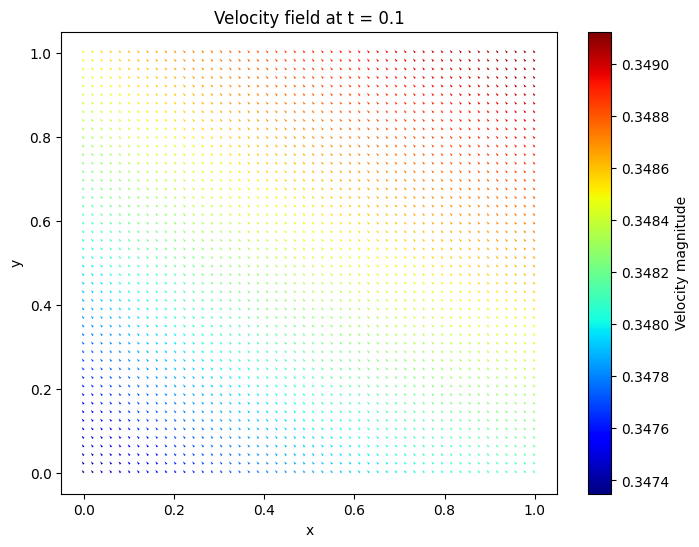

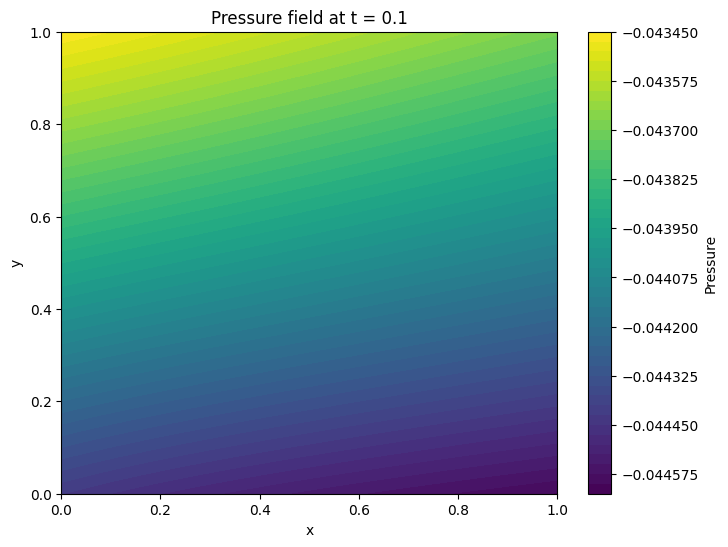

In [23]:
# Generate a grid of points in the spatial domain at time t
nx, ny = 50, 50  # Number of grid points in x and y
x_min, x_max = 0.0, 1.0  # Spatial domain in x
y_min, y_max = 0.0, 1.0  # Spatial domain in y
t_value = 0.1  # Time at which to visualize

x = np.linspace(x_min, x_max, nx)
y = np.linspace(y_min, y_max, ny)
X, Y = np.meshgrid(x, y)
T = np.full_like(X, t_value)

# Flatten the grid arrays and convert to torch tensors
x_grid = torch.tensor(X.flatten(), dtype=torch.float32).unsqueeze(1)
y_grid = torch.tensor(Y.flatten(), dtype=torch.float32).unsqueeze(1)
t_grid = torch.tensor(T.flatten(), dtype=torch.float32).unsqueeze(1)

# Evaluate the model at the grid points
with torch.no_grad():
    u_pred, v_pred, p_pred = pinn(x_grid, y_grid, t_grid)

# Convert predictions to numpy arrays
U = u_pred.numpy().reshape(nx, ny)
V = v_pred.numpy().reshape(nx, ny)
P = p_pred.numpy().reshape(nx, ny)

# Compute velocity magnitude
velocity_magnitude = np.sqrt(U**2 + V**2)

# Plot the velocity field using quiver
plt.figure(figsize=(8, 6))
plt.quiver(X, Y, U, V, velocity_magnitude, scale=50, cmap='jet')
plt.colorbar(label='Velocity magnitude')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Velocity field at t = {t_value}')
plt.show()

# Plot the pressure field using contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, P, levels=50, cmap='viridis')
plt.colorbar(contour, label='Pressure')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Pressure field at t = {t_value}')
plt.show()

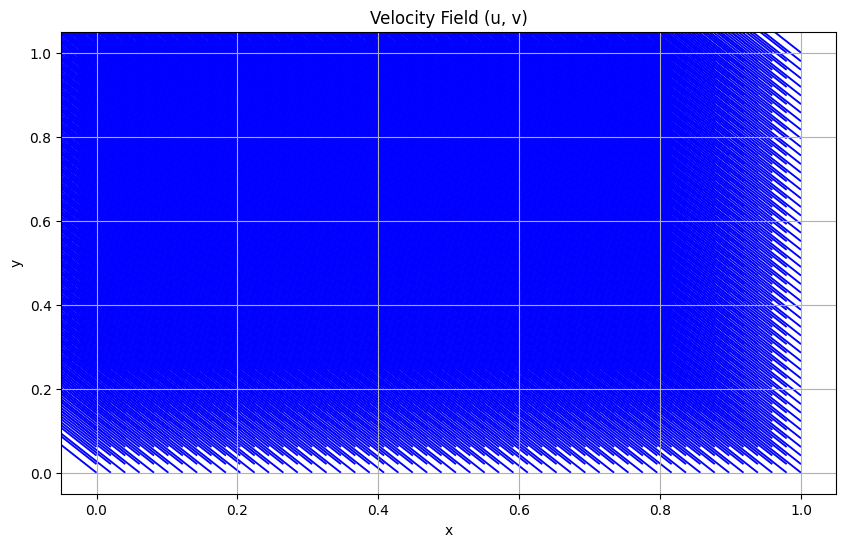

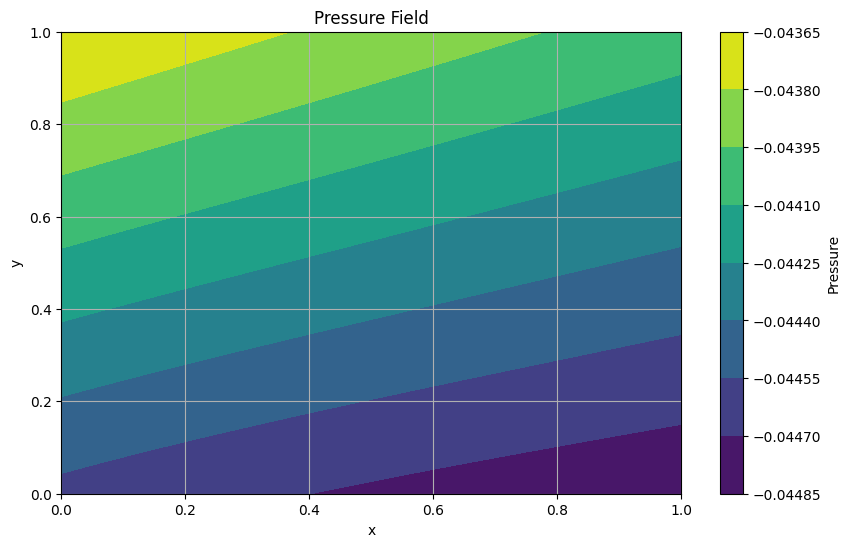

In [24]:
# Define a grid for visualization
x_vals = np.linspace(0, 1, 50)
y_vals = np.linspace(0, 1, 50)
t_val = 1.0

x_grid, y_grid = np.meshgrid(x_vals, y_vals)
x_flat = torch.tensor(x_grid.flatten(), dtype=torch.float32).unsqueeze(-1)
y_flat = torch.tensor(y_grid.flatten(), dtype=torch.float32).unsqueeze(-1)
t_flat = torch.tensor(np.full_like(x_flat, t_val), dtype=torch.float32)

u_pred, v_pred, p_pred = pinn(x_flat, y_flat, t_flat)

u_grid = u_pred.detach().numpy().reshape(x_grid.shape)
v_grid = v_pred.detach().numpy().reshape(x_grid.shape)
p_grid = p_pred.detach().numpy().reshape(x_grid.shape)

# Velocity field (quiver plot)
plt.figure(figsize=(10, 6))
plt.quiver(x_grid, y_grid, u_grid, v_grid, color='b', angles='xy', scale_units='xy', scale=1)
plt.title("Velocity Field (u, v)")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()

# Pressure field (heatmap)
plt.figure(figsize=(10, 6))
plt.contourf(x_grid, y_grid, p_grid, cmap='viridis')
plt.colorbar(label="Pressure")
plt.title("Pressure Field")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()

In [25]:
import torch
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt
import imageio

# Function to save pressure field images
def save_pressure_field_gif(model, nx=50, ny=50, x_min=0.0, x_max=1.0, y_min=0.0, y_max=1.0, t_start=0, t_end=30, num_frames=100):
    x = np.linspace(x_min, x_max, nx)
    y = np.linspace(y_min, y_max, ny)
    X, Y = np.meshgrid(x, y)

    # Prepare directory for images
    images = []
    times = np.linspace(t_start, t_end, num_frames)

    for i, t_value in enumerate(times):
        T = np.full_like(X, t_value)
        
        # Flatten the grid arrays and convert to torch tensors
        x_grid = torch.tensor(X.flatten(), dtype=torch.float32).unsqueeze(1)
        y_grid = torch.tensor(Y.flatten(), dtype=torch.float32).unsqueeze(1)
        t_grid = torch.tensor(T.flatten(), dtype=torch.float32).unsqueeze(1)
        
        # Evaluate the model at the grid points
        with torch.no_grad():
            _, _, p_pred = model(x_grid, y_grid, t_grid)
        
        # Convert predictions to numpy array and reshape
        P = p_pred.numpy().reshape(nx, ny)

        # Create a figure and save the pressure field plot
        plt.figure(figsize=(6, 5))
        contour = plt.contourf(X, Y, P, levels=50, cmap='viridis')
        # plt.colorbar(contour, label='Pressure')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(f'Pressure field at t = {t_value:.2f}s')
        
        # Save the plot as a temporary image file
        filename = f"pressure/pressure_field_{i}.png"
        plt.savefig(filename)
        plt.close()
        
        # Append the filename to the list of images
        images.append(imageio.imread(filename))
    
    # Create a GIF from the saved images
    imageio.mimsave('pressure_field_evolution.gif', images, fps=10)
    print("GIF saved as 'pressure_field_evolution.gif'")

# Example usage (assuming the model is trained):
save_pressure_field_gif(pinn, nx=50, ny=50, x_min=0.0, x_max=1.0, y_min=0.0, y_max=1.0, t_start=0, t_end=30, num_frames=100)


C:\Users\user\AppData\Local\Temp\ipykernel_5808\3640238048.py:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


GIF saved as 'pressure_field_evolution.gif'
